# Opal Data
NSW Transport recently released a new dataset of Opal (transportation card) tap on/offs for 2 weeks. 
https://opendata.transport.nsw.gov.au/dataset/opal-tap-on-and-tap-off

## Initial Exploration
We'll need to deal with any quirks of our data.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

plt.style.use("ggplot")
df = pd.read_csv("D:/Downloads/time-loc_20160725-31.csv", dtype={'date':'str'})

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215630 entries, 0 to 215629
Data columns (total 6 columns):
mode     215630 non-null object
date     215630 non-null object
tap      215630 non-null object
time     215630 non-null object
loc      215630 non-null object
count    215630 non-null int64
dtypes: int64(1), object(5)
memory usage: 9.9+ MB


In [46]:
df.head()

,mode,date,tap,time,loc,count
0,bus,20160730,on,2:30,2000,415
1,bus,20160730,on,2:30,2135,18
2,bus,20160730,on,2:30,-1,24
3,bus,20160730,on,2:30,2010,31
4,bus,20160730,on,13:30,2095,64


Looking at the data we can see that most of the data is in string format, and so we're going to want to make some adjustments to our dates. We also see/know that the time and loc fields both contain a "-1" string when there was no relevant data.

In [47]:
df.groupby(["time"]).count()
df = df[df.time != "-1"]
df["datefull"] = df.date + " " + df.time
df["datefull"] = pd.to_datetime(df.datefull, format = "%Y%m%d %H:%M", utc = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215581 entries, 0 to 215629
Data columns (total 7 columns):
mode        215581 non-null object
date        215581 non-null object
tap         215581 non-null object
time        215581 non-null object
loc         215581 non-null object
count       215581 non-null int64
datefull    215581 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 13.2+ MB


## Data Visualisation
Even with a fairly basic dataset, we can explore quite a few different avenues, and see if we can answer some basic questions. Areas of interest include:
* Regular behaviour of travellers (time & mode)
* Location 
* Ratios of tap on/tap offs

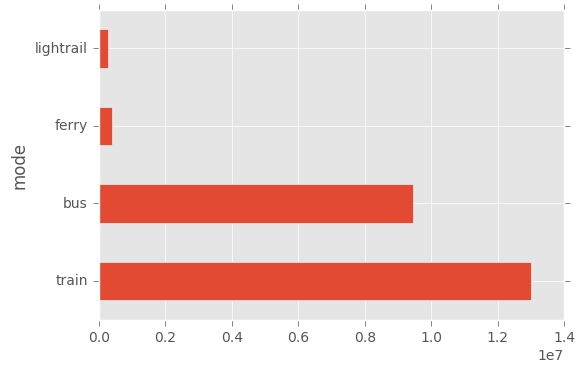

In [48]:
df.groupby(["mode"]).sum()["count"].sort_values(ascending = False).plot(kind="barh")
plt.show()

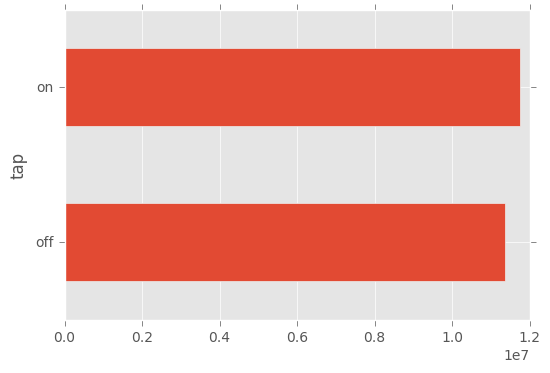

In [49]:
df.groupby(["tap"]).sum()["count"].plot(kind="barh")
plt.show()

### Time Analysis
We expect some fairly regular behaviour from travellers during the week, with hours being dominated by peak travel hours in the morning/evening. We can explore both trends across the week, as well as trends across the day.

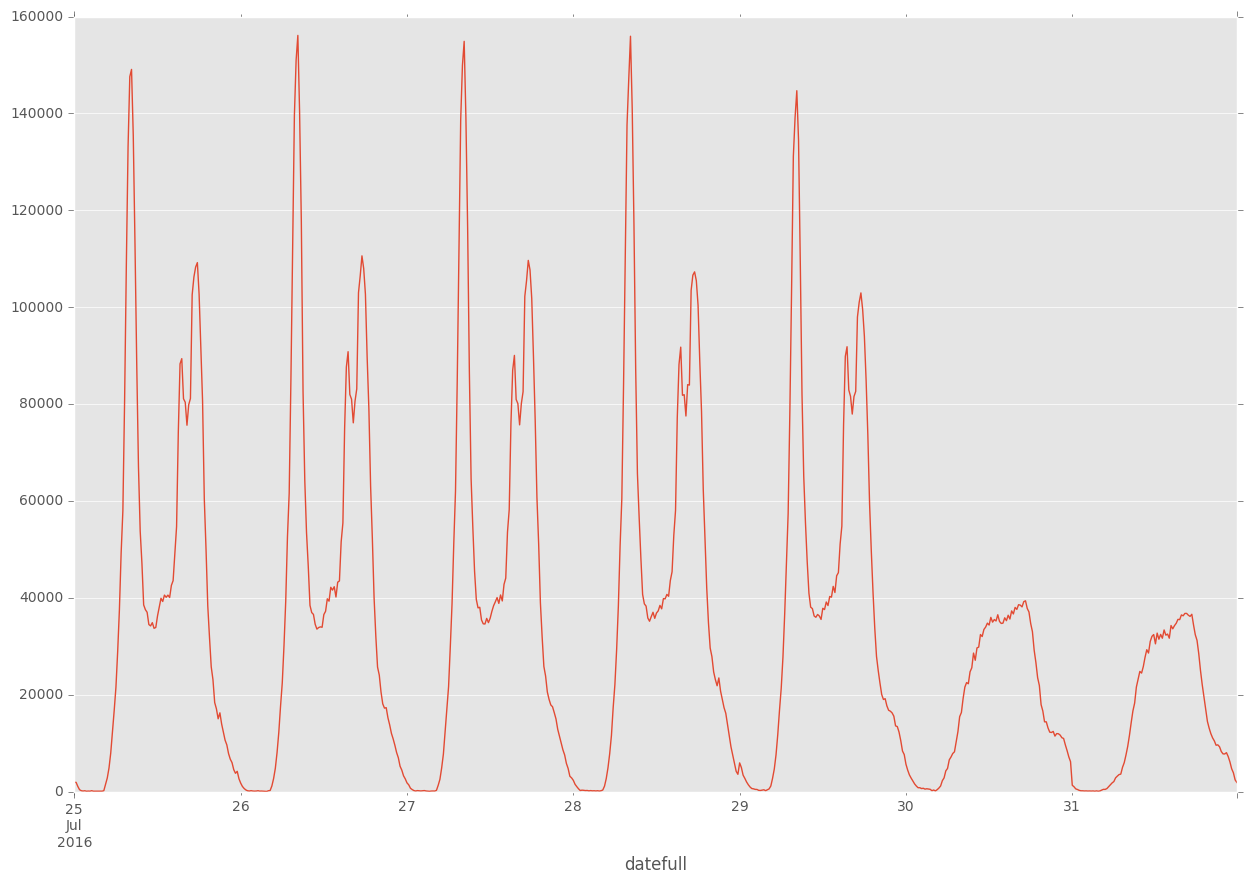

In [50]:
plt.figure(figsize=(15,10))
df.groupby(["datefull"]).sum()["count"].plot()
plt.show()

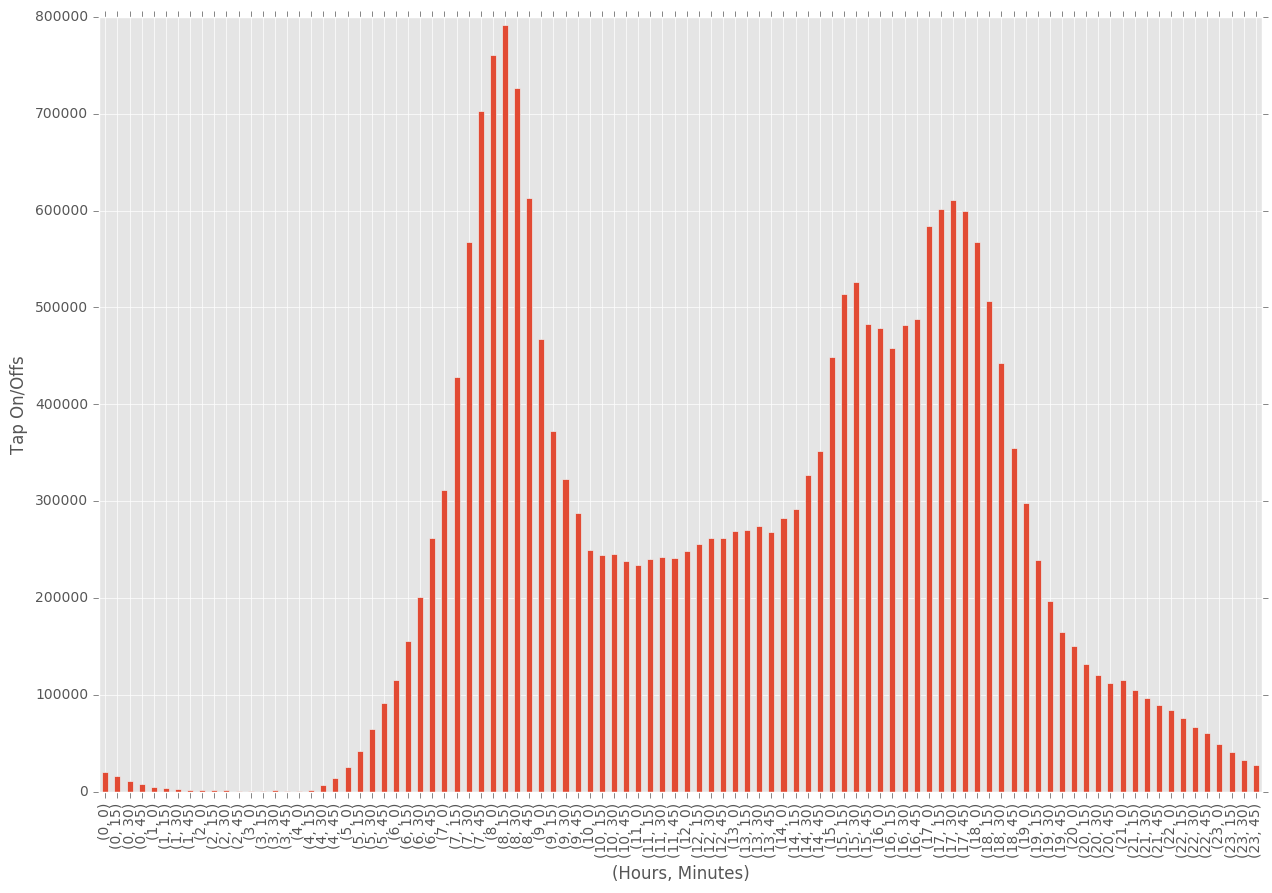

In [51]:
times = pd.DatetimeIndex(df.datefull)

plt.figure(figsize=(15,10))
df.groupby([times.hour, times.minute])["count"].sum().plot(kind="bar")
plt.xlabel("(Hours, Minutes)")
plt.ylabel("Tap On/Offs")
plt.show()

### Location Analysis
Naturally we expect the Sydney CBD to dominate in usage, given the high thoroughfare through these areas in terms of population and workers.

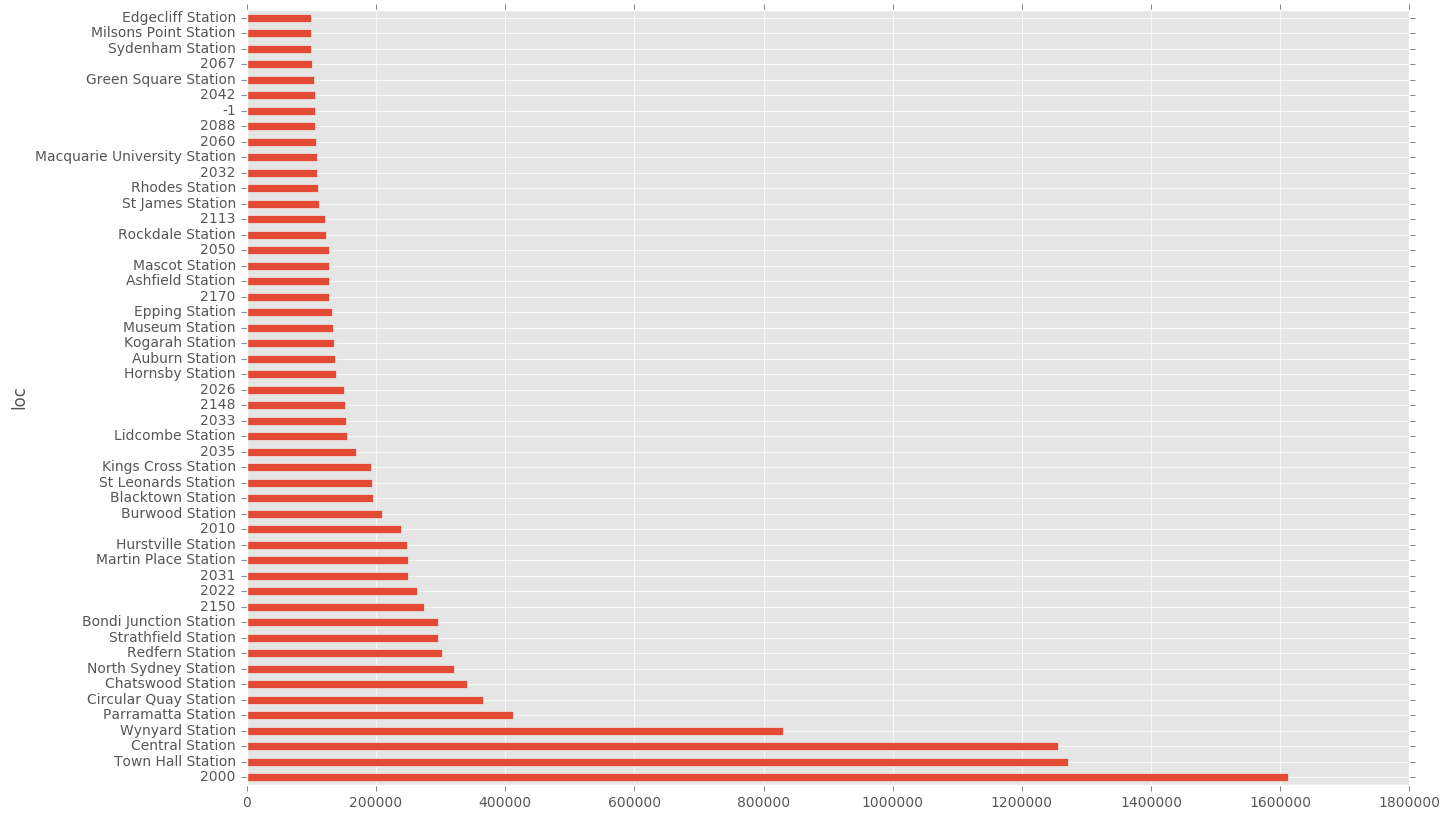

In [52]:
plt.figure(figsize=(15,10))
df.groupby(["loc"])["count"].sum().sort_values(ascending=False)[0:50].plot(kind="barh")
plt.show()

Another interesting area is to test location and time of tap on/off. I would expect more regularity in peoples departure times in the morning, and so would expect to see more tap-ons in the morning as opposed to the evening.

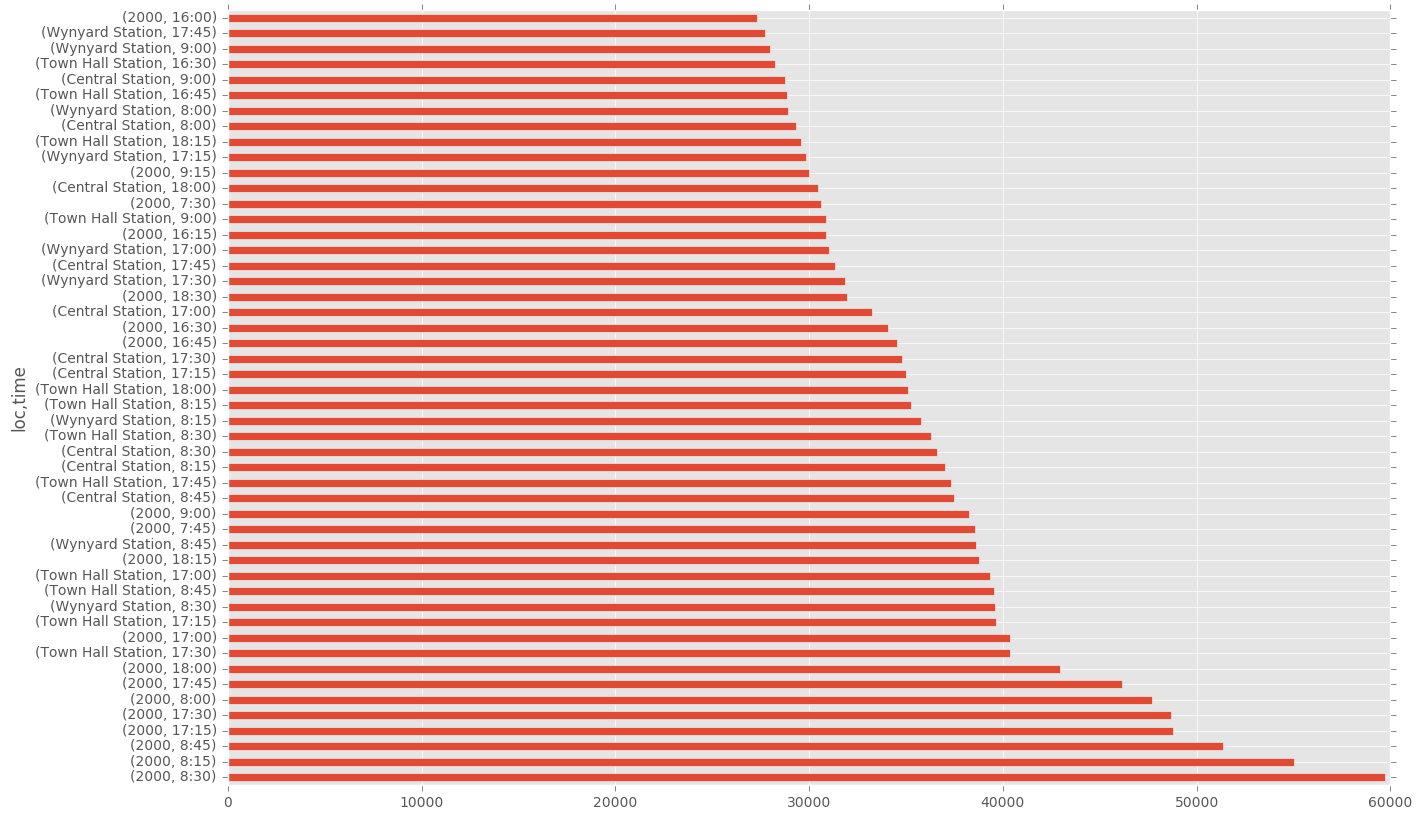

In [53]:
plt.figure(figsize=(15,10))
df.groupby(["loc", "time"])["count"].sum().sort_values(ascending=False)[0:50].plot(kind="barh")
plt.show()

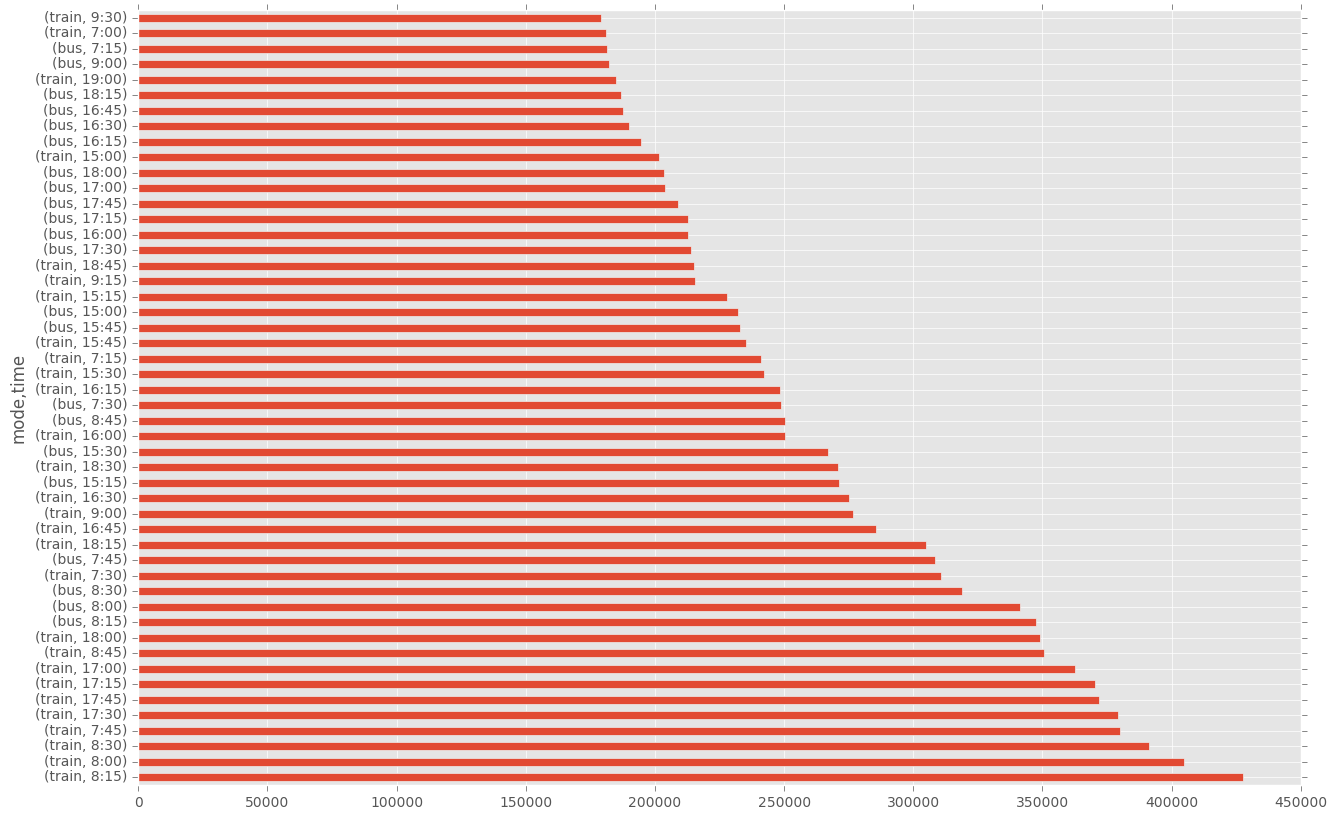

In [55]:
plt.figure(figsize=(15,10))
df.groupby(["mode", "time"])["count"].sum().sort_values(ascending=False)[0:50].plot(kind="barh")
plt.show()

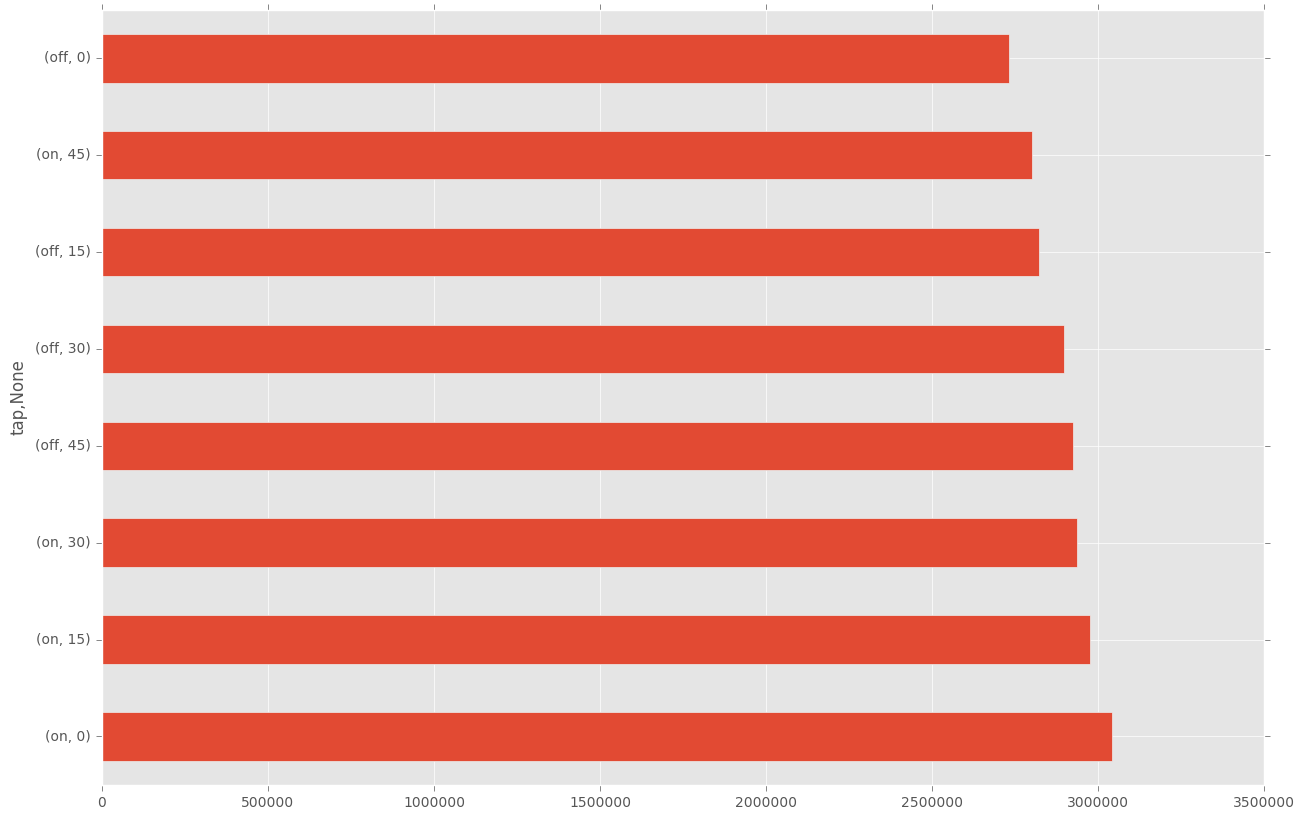

In [56]:
plt.figure(figsize=(15,10))
df.groupby(["tap", times.minute])["count"].sum().sort_values(ascending=False)[0:50].plot(kind="barh")
plt.show()

### Mode Analysis
In Sydney I expect trains and buses to be the dominant form of transport. We can look at both daily and hourly trends.

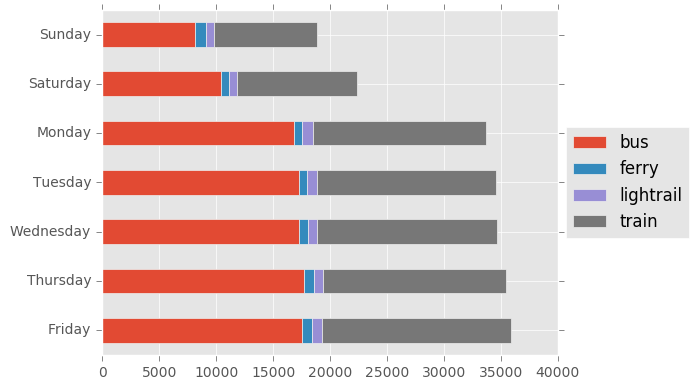

In [60]:
cr_counts = pd.DataFrame(df["mode"].value_counts())
top10 = df
tmp2 = pd.DataFrame(top10.groupby([times.day,"mode"]).size(), columns = ['count'])
tmp2.reset_index(inplace=True)
tmp2 = tmp2.replace({25:"Monday",
                        26:"Tuesday",
                        27:"Wednesday",
                        28:"Thursday",
                        29:"Friday",
                        30:"Saturday",
                        31:"Sunday",})

tmp2 = tmp2.pivot(index="level_0", columns = "mode", values = 'count')
tmp2["total"] = tmp2.sum(axis=1)
tmp2 = tmp2.sort_values(by = "total", ascending = False)


del tmp2["total"]

tmp2.plot(kind = 'barh', stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("")
plt.tight_layout()
plt.show()

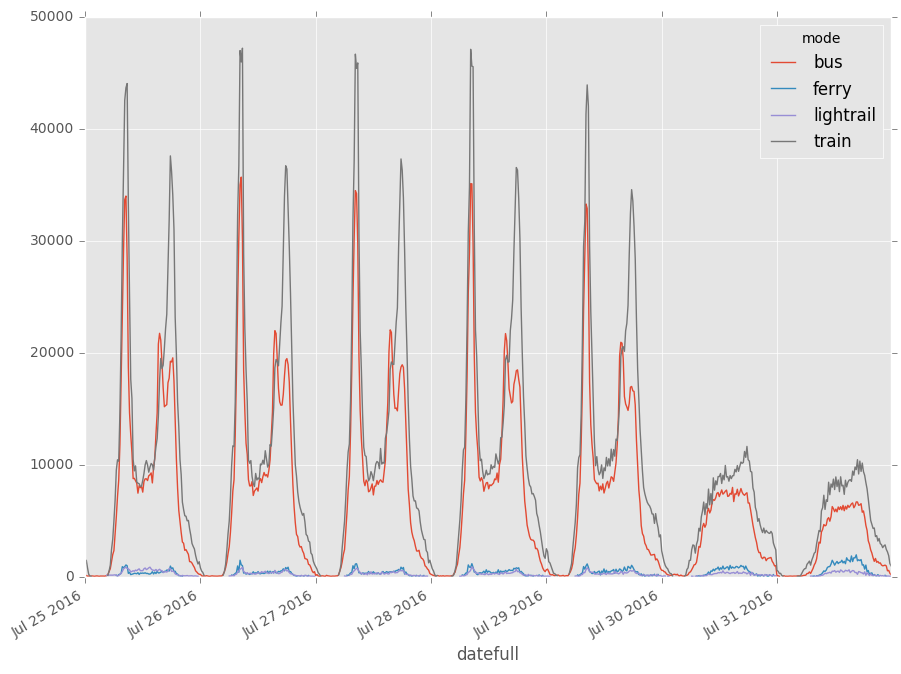

In [62]:
f = plt.figure(figsize = (13,8))
ax = f.gca()
#Plots by year
df_cat = df[df["tap"] == "off"]
df_cat = df_cat[["datefull", "mode", "count"]]
df_cat = df_cat.groupby([df_cat["datefull"], "mode"]).sum()["count"]
df_cat.unstack().plot(ax=ax)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
plt.show()


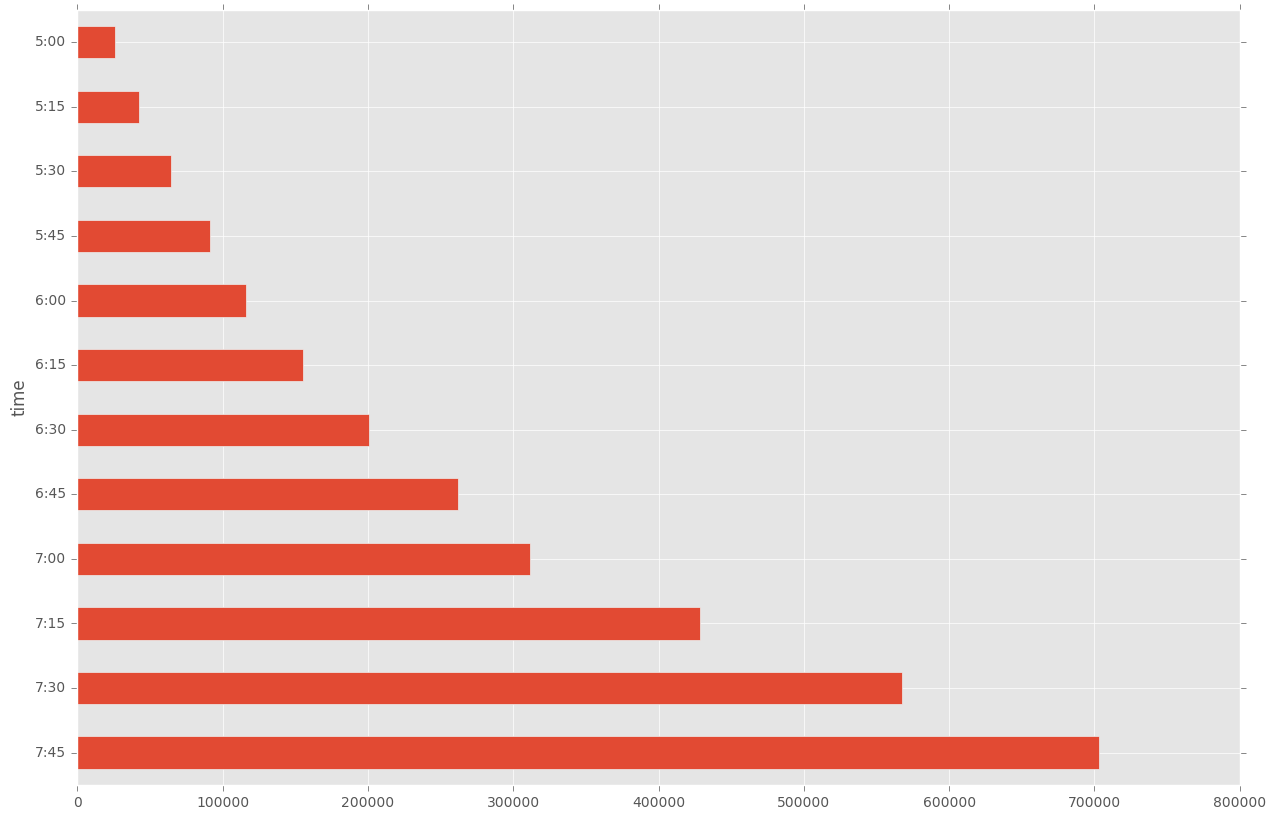

In [63]:
plt.figure(figsize=(15,10))
tmp = df[((times.hour < 8) & (times.hour > 4))]
tmp.groupby(["time"])["count"].sum().sort_values(ascending=False)[0:50].plot(kind="barh")
plt.show()

### Extra Analysis
We can now look at some more complicated charts, by breaking up interesting areas of analysis into different compartments. The first one is to look at a breakdown of times based on the major stations that are being used.

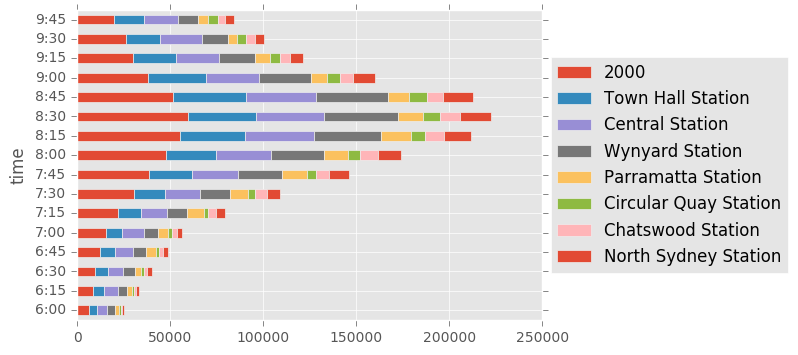

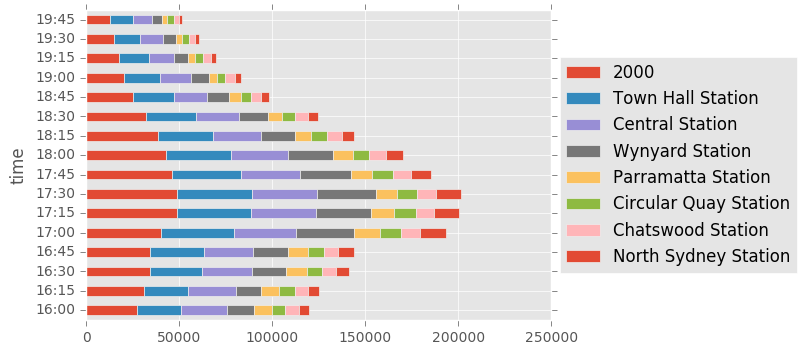

In [64]:
tmp = df[((times.hour <= 9) & (times.hour >= 6))]

cr_counts = tmp.loc[:, ["loc", "count"]].groupby(["loc"]).sum()["count"]
df_run = tmp.loc[:, ["time", "loc", "count"]].groupby(["time","loc"])

tmp2 = pd.DataFrame(df_run.sum()["count"], columns = ['count'])

tmp2.reset_index(inplace=True)
tmp2 = tmp2.pivot(index="time", columns = "loc", values = 'count')

vals = df.groupby(["loc"])["count"].sum().sort_values(ascending=False)[0:8]
tmp2[vals.index].plot(kind="barh", stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()


tmp = df[((times.hour <= 19) & (times.hour >= 16))]

cr_counts = tmp.loc[:, ["loc", "count"]].groupby(["loc"]).sum()["count"]
df_run = tmp.loc[:, ["time", "loc", "count"]].groupby(["time","loc"])

tmp2 = pd.DataFrame(df_run.sum()["count"], columns = ['count'])

tmp2.reset_index(inplace=True)
tmp2 = tmp2.pivot(index="time", columns = "loc", values = 'count')

vals = df.groupby(["loc"])["count"].sum().sort_values(ascending=False)[0:8]
tmp2[vals.index].plot(kind="barh", stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

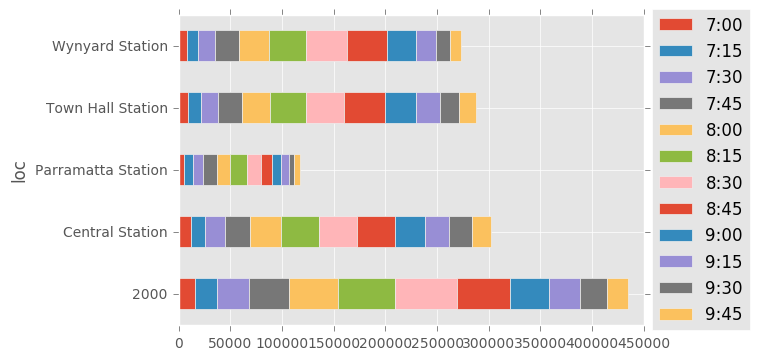

In [65]:
tmp = df[((times.hour <= 9) & (times.hour >= 7))]
cr_counts = tmp.loc[:, ["loc", "count"]].groupby(["loc"]).sum()["count"]
df_run = tmp.loc[:, ["time", "loc", "count"]].groupby(["time","loc"])

tmp2 = pd.DataFrame(df_run.sum()["count"], columns = ['count'])

tmp2.reset_index(inplace=True)
tmp2 = tmp2.pivot(index="loc", columns = "time", values = 'count')


plt.figure(figsize=(15,10))
vals = df.groupby(["loc"])["count"].sum().sort_values(ascending=False)[0:5]
tmp2[tmp2.index.isin(vals.index)].plot(kind="barh", stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Time-Evolving Maps

Our first step is to get the latitudes and longitudes for all of our locations. We can push this through the Googlemaps API see [here](https://developers.google.com/maps/documentation/geocoding/intro) for some more info. We'll iterate through our list of post codes and station names, and pull all our latitudes/longitudes and then join them to our initial dataset.

In [3]:
import requests

# Initialise our dataframe to store our latitude and longitude data
suburbs = pd.DataFrame(np.unique(df["loc"]), columns = ["loc"])
suburbs["lat"]= np.zeros(len(suburbs))
suburbs["lon"] = np.zeros(len(suburbs))
failed = []

for i in range(0, len(suburbs)):
    temp = suburbs.loc[i, "Suburb"]
    try:
        # Create the address we want to retriever from GoogleMaps
        addr = temp + ",+NSW,+Australia" 
        response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+addr)
        resp_json_payload = response.json()
        data = resp_json_payload['results'][0]['geometry']['location']
        lat = data["lat"]
        lon = data["lng"]
        #print(addr," ",lat," ",lon)
    except:
        # Create a list of fails, and then we can deal with individually if we have to
        failed.append(temp)
        lat = "NA"
        lon = "NA"
        print("No data on ", temp)
    
    suburbs.loc[i, "lat"] = lat
    suburbs.loc[i, "lon"] = lon
    
suburbs[suburbs["Suburb"] == "-1"] = [-1, "NA", "NA"] # -1 actually retrieves an address, so we want to set it to NA.
suburbs.to_csv("suburb_list.csv")
df = df.merge(suburbs, on = "loc", how = "left")

-1,+NSW,+Australia   -32.8284815   151.5285738
2000,+NSW,+Australia   -33.8708464   151.20733
2007,+NSW,+Australia   -33.8823187   151.197131
2008,+NSW,+Australia   -33.8878872   151.1964025
2009,+NSW,+Australia   -33.8687895   151.1942171
2010,+NSW,+Australia   -33.8825595   151.2131584
2011,+NSW,+Australia   -33.8710844   151.2233585
2015,+NSW,+Australia   -33.9087966   151.195674
2016,+NSW,+Australia   -33.892215   151.205873
2017,+NSW,+Australia   -33.9015357   151.20733
2018,+NSW,+Australia   -33.9219899   151.20733
2019,+NSW,+Australia   -33.9821687   151.1927601
2020,+NSW,+Australia   -33.9383158   151.1811052
2021,+NSW,+Australia   -33.8921203   151.2306446
2022,+NSW,+Australia   -33.8956547   151.2495903
2023,+NSW,+Australia   -33.8826955   151.2539627
2024,+NSW,+Australia   -33.9046399   151.2597927
2025,+NSW,+Australia   -33.8865002   151.2437606
2026,+NSW,+Australia   -33.8922511   151.2714535
2027,+NSW,+Australia   -33.87222879999999   151.2379312
2028,+NSW,+Australia   -3

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.lines as mlines

data_20160725 = df#[df.date == "20160725"] # Filter on a specific date

# Loop through all  individual times
for t in np.unique(data_20160725.datefull):
    fig = plt.figure(figsize=(15,10))
 
    # Extract out relevant date (latitude, longitude, type of tap and total counts)
    data = data_20160725[data_20160725.datefull == t]
    data = data.groupby(["lat", "lon", "tap"]).sum()["count"]
    vals = data.index.get_values()
    x = [x for x,y,z in vals]
    y = [y for x,y,z in vals]
    taps = [z for x,y,z in vals]
    # Create a new dataframe which is grouped by unique lat/lons
    new_data = pd.DataFrame(columns = ["x", "y", "taps", "count"])
    new_data["x"] = x
    new_data["y"] = y
    new_data["taps"] = taps
    new_data["count"] = data.values
    
    on_data = new_data[new_data.taps == "on"]
    off_data = new_data[new_data.taps == "off"]
    
    ####################################################################################
    # Create the Basemap object, set the lon/lat for our map 
    m = Basemap(projection='merc',
    resolution = 'i' ,llcrnrlon=150.614385, llcrnrlat=-33.949563,
              urcrnrlon=151.324376,urcrnrlat=-33.653431,)
     
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='white')
    
    # Transform points into Map's projection
    xs,ys = m(list(on_data["y"]), list(on_data["x"]))
    
    crimes = on_data["count"]
    
    # Iterate over tap on/tap off data, and scale marker based on density
    min_marker_size = 10
    for lon, lat, mag in zip(list(on_data["y"]), list(on_data["x"]), crimes):
        x,y = m(lon, lat)
        msize = mag/200 * min_marker_size
        m.plot(x, y, 'ro',markersize=msize)
        
    for lon, lat, mag in zip(list(off_data["y"]), list(off_data["x"]), off_data["count"]):
        x,y = m(lon, lat)
        msize = mag/200 * min_marker_size
        m.plot(x, y,'bo', markersize=msize)
            

    name = pd.to_datetime(str(t)).strftime('%Y_%m_%d_%H_%M')
    plt.annotate('%s'%name,xy=(0.05,0.05),xytext=(0.05,0.05),xycoords='axes fraction',fontsize=12)
    
    # Manually set the legend, due to us varying the markersizes
    red_patch = mlines.Line2D([],[],color='red', marker = 'o', label='Tap On')
    blue_patch = mlines.Line2D([],[],color='blue', marker = 'o', label='Tap Off')
    plt.legend(handles=[red_patch, blue_patch], loc = "upper left")

    # Write some station names to our map
    stations = ["Penrith Station", "Blacktown Station", "Parramatta Station", "Strathfield Station",
                "Central Station", "Town Hall Station", "Wynyard Station", "North Sydney Station", "Chatswood Station", 
                "Circular Quay Station"]
                
    for i in stations:   
        x,y = m(suburbs[suburbs["loc"] == i]["lon"].values, suburbs[suburbs["loc"] == i]["lat"].values)
        plt.text(x,y, i)
    
    fig.savefig("image/"+name+".png")
    plt.close(fig)
    
    

The above will produce us a whole bunch of images, but what we really want is an animated set of images!

In [ ]:
import imageio
from os import listdir
from os.path import isfile, join
mypath = "/mypath/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

t = ["2016_07_30" in x for x in onlyfiles]
files = list(compress(onlyfiles, t))
images = []
filenames = files
for filename in filenames:
    images.append(imageio.imread("image/"+filename))
imageio.mimsave('movie_20160730.gif', images)